c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_io.py:140: UserWarning: c:/temp/000074.png is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint16.
  .format(dtypeobj_in, dtypeobj_out))
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from int16 to uint16
  .format(dtypeobj_in, dtypeobj_out))
c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


(512, 512)
(512, 512)
Compressed PNG:          SSIM =  0.21221317063099174        MSE =  394176.0593948364


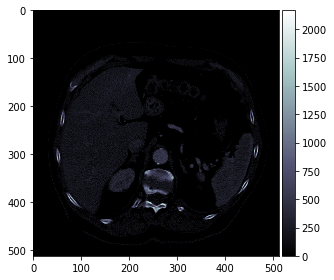

In [15]:
import os
import pydicom
import pywt
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse

def compare_images(title, original, processed):
    mse_noise = mse(original, processed)
    ssim_noise = ssim(original, processed, data_range=processed.max() - processed.min())
    print(title, "        SSIM = ", ssim_noise, "       MSE = ", mse_noise)

    
# read image
ds = pydicom.dcmread("c:/temp/000074.dcm")

# convert to HounsField Scale
image = np.stack(ds.pixel_array)

# Convert to int16 (from sometimes int16), 
# should be possible as values should always be low enough (<32k)
image = image.astype(np.int16)

# Set outside-of-scan pixels to 1
# The intercept is usually -1024, so air is approximately 0
image[image == -2000] = 0

intercept = ds.RescaleIntercept
slope = ds.RescaleSlope
    
if slope != 1:
	image = slope * image.astype(np.float64)
	image = image.astype(np.int16)
        
image += np.int16(intercept)
    
imgs = np.array(image, dtype=np.float64)

# save image
bimg = plt.imshow(imgs, cmap=plt.cm.bone)
io.imsave('c:/temp/000074.png', image)

png = io.imread('c:/temp/000074.png')

print(png.shape)
print(image.shape)

#io.imshow(image, cmap=plt.cm.bone)
io.imshow(png, cmap=plt.cm.bone)

compare_images("Compressed PNG: ", image, png)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


Exposure Rescale Intensity:          SSIM =  0.5289206792857991        MSE =  369247475.44714355


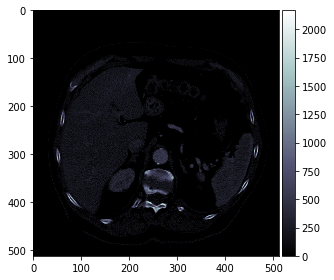

In [20]:
from skimage import exposure

p2, p98 = np.percentile(png, (2, 98))
img_rescale = exposure.rescale_intensity(png, in_range=(p2, p98))
io.imshow(png, cmap=plt.cm.bone)
compare_images("Exposure Rescale Intensity: ", png, img_rescale)

Wavelet Denoise after Rescale Intensity:          SSIM =  1.5934166253162154e-05        MSE =  394138.70166278887


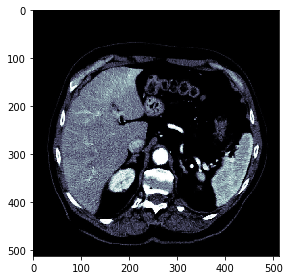

In [21]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

# Wavelet Denoise after Rescale Intensity
img_resc_wavelet2 = denoise_wavelet(img_rescale, multichannel=False)
io.imshow(img_resc_wavelet2, cmap=plt.cm.bone)
compare_images("Wavelet Denoise after Rescale Intensity: ", image, img_resc_wavelet2)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in short_scalars
  if sys.path[0] == '':


Exposure Rescale Intensity:          SSIM =  0.011597795698408055        MSE =  697385996.2030983


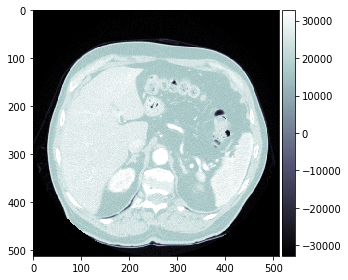

In [22]:
p2, p98 = np.percentile(image, (2, 98))
img_rescale2 = exposure.rescale_intensity(image, in_range=(p2, p98))
io.imshow(img_rescale2, cmap=plt.cm.bone)
compare_images("Exposure Rescale Intensity: ", image, img_rescale2)

Wavelet Denoise after Rescale Intensity:          SSIM =  0.00035804240932151346        MSE =  393402.3770665297


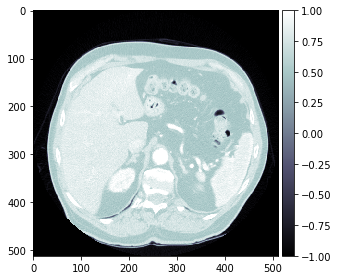

In [23]:
# Wavelet Denoise after Rescale Intensity
img_resc_wavelet = denoise_wavelet(img_rescale2, multichannel=False)
io.imshow(img_resc_wavelet, cmap=plt.cm.bone)
compare_images("Wavelet Denoise after Rescale Intensity: ", image, img_resc_wavelet)

c:\users\hp\appdata\local\programs\python\python35\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(512, 512)
(512, 512)
Compressed Denoised PNG:          SSIM =  0.3460561429049256        MSE =  1344725486.2630608
Compressed PNG:          SSIM =  0.10129408141011491        MSE =  1343155125.4296074


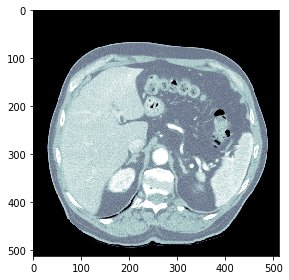

In [25]:
io.imsave('c:/temp/000074.png', img_resc_wavelet)

png2 = io.imread('c:/temp/000074.png')

print(png.shape)
print(image.shape)

#io.imshow(image, cmap=plt.cm.bone)
io.imshow(png2, cmap=plt.cm.bone)

compare_images("Compressed Denoised PNG: ", img_resc_wavelet, png2)
compare_images("Compressed PNG: ", image, png2)